In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%reload_ext autoreload
%aimport model
%aimport config

from model import load_model
from config import temporal_saturation, temporal_depth, batch_size, skipping_strides
from config import normalize_minmax

Using TensorFlow backend.


In [3]:
def load_video(fn):
    data = np.load(fn)
    frames = data.shape[2]
    print('Load {} with shape {}'.format(fn, data.shape))
    if frames <= temporal_saturation*temporal_depth:
        raise Exception('not enought data for sample')
    return np.expand_dims(data, axis=3)

def load_data(data_list, s=None):
    X = []
    with open(data_list, 'r') as f:
        for line in f.readlines():
            try:
                fn = '{}.npy'.format(line[:-1])
                data = load_video(fn)
                if s:
                    sigma = np.sqrt(s)
                    data = np.clip(data, -3*sigma, 3*sigma)
                    data = normalize_minmax(data, (-1, 1))
                X.append(data)
            except Exception as e:
                print(e)
    return X

_, s = np.load('train_avenue/gmm.npy')
X_train = load_data('train_avenue.list')
X_val = load_data('val_avenue.list')
X_train[0].shape

Load train_avenue/01.avi.npy with shape (227, 227, 820)
Load train_avenue/02.avi.npy with shape (227, 227, 909)
Load train_avenue/03.avi.npy with shape (227, 227, 894)
Load train_avenue/04.avi.npy with shape (227, 227, 909)
Load train_avenue/05.avi.npy with shape (227, 227, 491)
Load train_avenue/06.avi.npy with shape (227, 227, 909)
Load train_avenue/09.avi.npy with shape (227, 227, 837)
Load train_avenue/10.avi.npy with shape (227, 227, 736)
Load train_avenue/11.avi.npy with shape (227, 227, 471)
Load train_avenue/12.avi.npy with shape (227, 227, 89)
Load train_avenue/13.avi.npy with shape (227, 227, 222)
Load train_avenue/14.avi.npy with shape (227, 227, 308)
Load train_avenue/15.avi.npy with shape (227, 227, 214)
Load train_avenue/07.avi.npy with shape (227, 227, 661)
Load train_avenue/08.avi.npy with shape (227, 227, 612)
Load train_avenue/16.avi.npy with shape (227, 227, 148)


(227, 227, 820, 1)

In [4]:
def draw_distribution(X, sigma=None):
    for x in X:
        plt.subplot('111')
        data = x.ravel()
        if sigma:
            data = np.clip(data, -sigma, sigma)
        plt.hist(data, bins=100, alpha=0.2)

def visualize_last(sample):
    sample = sample[:,:,temporal_depth-1,0]
    print(sample.shape)
    print(np.min(sample), np.max(sample), np.unique(sample).shape[0])
    plt.imshow(sample)

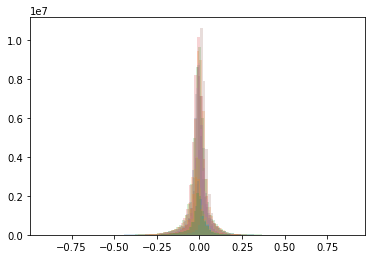

In [5]:
draw_distribution(X_train)

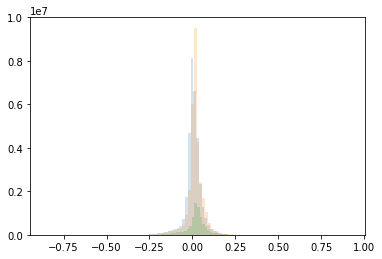

In [6]:
draw_distribution(X_val)

In [7]:
train_len = np.sum([x.shape[2] for x in X_train])
val_len = np.sum([x.shape[2] for x in X_val])
train_len, val_len

(7809, 1421)

(227, 227)
-0.519857425447311 0.5457572893342237 51464


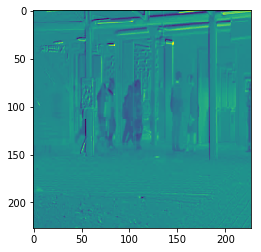

In [8]:
visualize_last(X_train[0])

In [9]:
model_fn = 'avenue.h5'
model = load_model(model_fn)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 10, 128)   512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 55, 55, 10, 128)   204928    
__________

In [10]:
from time import time

def random_sample(x):
    step = temporal_saturation
    sample_len = step * temporal_depth
    start = np.random.randint(0, x.shape[2] - sample_len)
    ss = np.random.choice(skipping_strides)
    indices = np.array([start + int(i*step*ss) for i in range(temporal_depth)])
    return np.expand_dims(x[:,:,indices,:], axis=0)

def data_generator(X):
    total = len(X)
    p = np.array([x.shape[2] for x in X])
    p = p / np.sum(p)
    while True:
        batch=None
        for _ in range(batch_size):
            idx = np.random.choice(range(total), p=p)
            sample = random_sample(X[idx])
            batch = sample if type(batch) != np.ndarray else np.vstack((batch, sample)) # too long...
        yield [batch, batch]

train_generator = data_generator(X_train)
val_generator = data_generator(X_val)

In [11]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

scheduler = LearningRateScheduler(lambda epoch: 0.001 if epoch < 10 else 0.0005 if epoch < 30 else 0.0001)
#scheduler = LearningRateScheduler(lambda epoch: 0.00005 if epoch < 150 else 0.00001)
checkpoint = ModelCheckpoint(model_fn,monitor='val_loss',verbose=1,save_best_only=True)

In [12]:
model.compile(optimizer='adam', loss='mse')

model.fit_generator(
    generator=train_generator,
    steps_per_epoch=40,
    epochs=100,
    validation_data=val_generator,
    validation_steps=10,
    callbacks=[scheduler, checkpoint],
    max_queue_size=16,
    #use_multiprocessing=True,
    workers=4)

Epoch 1/100
39/40 [============================>.] - ETA: 1s - loss: 0.0054 - acc: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.00263, saving model to avenue.h5
40/40 [==============================] - 60s 2s/step - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00
Epoch 00002: val_loss improved from 0.00263 to 0.00240, saving model to avenue.h5
40/40 [==============================] - 35s 866ms/step - loss: 0.0024 - acc: 0.0000e+00 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 3/100
39/40 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00
Epoch 00003: val_loss improved from 0.00240 to 0.00206, saving model to avenue.h5
40/40 [==============================] - 35s 866ms/step - loss: 0.0022 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.0000

Epoch 31/100
39/40 [============================>.] - ETA: 0s - loss: 9.4304e-04 - acc: 0.0000e+00
Epoch 00031: val_loss improved from 0.00098 to 0.00085, saving model to avenue.h5
40/40 [==============================] - 35s 867ms/step - loss: 9.4726e-04 - acc: 0.0000e+00 - val_loss: 8.5328e-04 - val_acc: 0.0000e+00
Epoch 32/100
39/40 [============================>.] - ETA: 0s - loss: 9.3422e-04 - acc: 0.0000e+00
Epoch 00032: val_loss improved from 0.00085 to 0.00079, saving model to avenue.h5
40/40 [==============================] - 35s 868ms/step - loss: 9.3565e-04 - acc: 0.0000e+00 - val_loss: 7.9444e-04 - val_acc: 0.0000e+00
Epoch 33/100
39/40 [============================>.] - ETA: 0s - loss: 9.5232e-04 - acc: 0.0000e+00
Epoch 00033: val_loss improved from 0.00079 to 0.00073, saving model to avenue.h5
40/40 [==============================] - 35s 872ms/step - loss: 9.5271e-04 - acc: 0.0000e+00 - val_loss: 7.3204e-04 - val_acc: 0.0000e+00
Epoch 34/100
39/40 [=======================

Epoch 60/100
39/40 [============================>.] - ETA: 0s - loss: 8.3579e-04 - acc: 0.0000e+00
Epoch 00060: val_loss did not improve
40/40 [==============================] - 35s 873ms/step - loss: 8.3394e-04 - acc: 0.0000e+00 - val_loss: 6.6804e-04 - val_acc: 0.0000e+00
Epoch 61/100
39/40 [============================>.] - ETA: 0s - loss: 8.3385e-04 - acc: 0.0000e+00
Epoch 00061: val_loss improved from 0.00065 to 0.00062, saving model to avenue.h5
40/40 [==============================] - 35s 875ms/step - loss: 8.3372e-04 - acc: 0.0000e+00 - val_loss: 6.1756e-04 - val_acc: 0.0000e+00
Epoch 62/100
39/40 [============================>.] - ETA: 0s - loss: 8.5364e-04 - acc: 0.0000e+00
Epoch 00062: val_loss did not improve
40/40 [==============================] - 35s 871ms/step - loss: 8.5946e-04 - acc: 0.0000e+00 - val_loss: 6.6828e-04 - val_acc: 0.0000e+00
Epoch 63/100
39/40 [============================>.] - ETA: 0s - loss: 8.5162e-04 - acc: 0.0000e+00
Epoch 00063: val_loss did not im

Epoch 90/100
39/40 [============================>.] - ETA: 0s - loss: 7.8324e-04 - acc: 0.0000e+00
Epoch 00090: val_loss did not improve
40/40 [==============================] - 36s 898ms/step - loss: 7.7939e-04 - acc: 0.0000e+00 - val_loss: 6.2780e-04 - val_acc: 0.0000e+00
Epoch 91/100
39/40 [============================>.] - ETA: 0s - loss: 7.6572e-04 - acc: 0.0000e+00
Epoch 00091: val_loss did not improve
40/40 [==============================] - 36s 905ms/step - loss: 7.6882e-04 - acc: 0.0000e+00 - val_loss: 6.5620e-04 - val_acc: 0.0000e+00
Epoch 92/100
39/40 [============================>.] - ETA: 0s - loss: 8.0259e-04 - acc: 0.0000e+00
Epoch 00092: val_loss did not improve
40/40 [==============================] - 35s 872ms/step - loss: 8.0370e-04 - acc: 0.0000e+00 - val_loss: 6.1069e-04 - val_acc: 0.0000e+00
Epoch 93/100
39/40 [============================>.] - ETA: 0s - loss: 7.6990e-04 - acc: 0.0000e+00
Epoch 00093: val_loss improved from 0.00061 to 0.00060, saving model to aven

In [13]:
#model.save(model_fn)

(227, 227)
-0.578916230086192 0.5215842601947638 51464


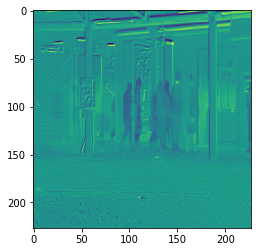

In [14]:
batch = np.expand_dims(X_train[0][:,:,np.array([i*temporal_saturation for i in range(temporal_depth)]),:], axis=0)
visualize_last(batch[0])

(227, 227)
-0.46412644 0.38736027 51510


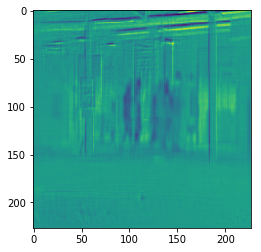

In [15]:
X_pred = model.predict(batch)
visualize_last(X_pred[0])